# Introduction to PyTorch-Geommetric

A graph is used to model pairwise relations (edges) between objects (nodes). A single graph in PyG is described by an instance of torch_geometric.data.Data, which holds the following attributes by default:

- data.x: Node feature matrix with shape [num_nodes, num_node_features]

- data.edge_index: Graph connectivity in COO format with shape [2, num_edges] and type torch.long

- data.edge_attr: Edge feature matrix with shape [num_edges, num_edge_features]

- data.y: Target to train against (may have arbitrary shape), e.g., node-level targets of shape [num_nodes, *] or graph-level targets of shape [1, *]

- data.pos: Node position matrix with shape [num_nodes, num_dimensions]

None of these attributes are required. In fact, the Data object is not even restricted to these attributes. We can, e.g., extend it by data.face to save the connectivity of triangles from a 3D mesh in a tensor with shape [3, num_faces] and type torch.long.


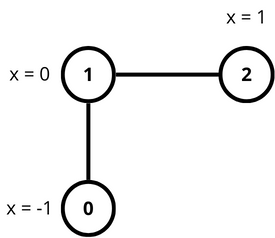

In [3]:
import torch
from torch_geometric.data import Data

edge_index = torch.tensor([[0, 1, 1, 2],
                           [1, 0, 2, 1]], dtype=torch.long)
x = torch.tensor([[-1], [0], [1]], dtype=torch.float)

data = Data(x=x, edge_index=edge_index)

print()
print(data)
print('===================================')

# Gather some statistics about the graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')


Data(x=[3, 1], edge_index=[2, 4])
Number of nodes: 3
Number of edges: 4
Average node degree: 1.33
Has isolated nodes: False
Has self-loops: False
Is undirected: True


# Node classification with PyTorch-Geommetric

In [4]:
# Install required packages.
import os
import numpy as np
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

# Helper function for visualization.
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def visualize(h, color, title):
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy()) # Dimention reduction algorithm
    palette = ["#9b5fe0", "#16a4d8", "#60dbe8", "#8bd346", "#efdf48", "#f9a52c", "#d64e12"]
    colors = [palette[color.detach().numpy()[i]] for i in range(len(color))]

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=colors)
    plt.title(title)
    plt.legend()
    plt.show()

2.2.0+cu121


The Cora dataset consists of 2708 scientific publications classified into one of seven classes. The citation network consists of 5429 links. Each publication in the dataset is described by a 0/1-valued word vector indicating the absence/presence of the corresponding word from the dictionary. The dictionary consists of 1433 unique words and each link between two papers means that one sites the other.


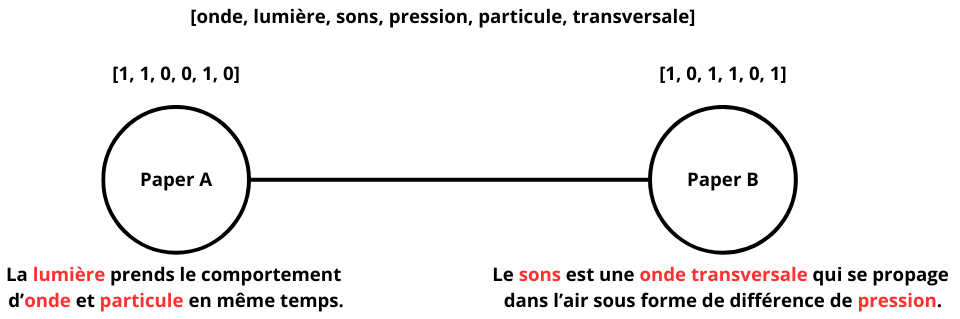

In [5]:
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures

dataset = Planetoid(root='data/Planetoid', name='Cora', transform=NormalizeFeatures())

print()
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]  # Get the first graph object.

print()
print(data)
print('===========================================================================================================')

# Gather some statistics about the graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')



Dataset: Cora():
Number of graphs: 1
Number of features: 1433
Number of classes: 7

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
Number of nodes: 2708
Number of edges: 10556
Average node degree: 3.90
Number of training nodes: 140
Training node label rate: 0.05
Has isolated nodes: False
Has self-loops: False
Is undirected: True


# Training a Multi-layer Perception Network (MLP)

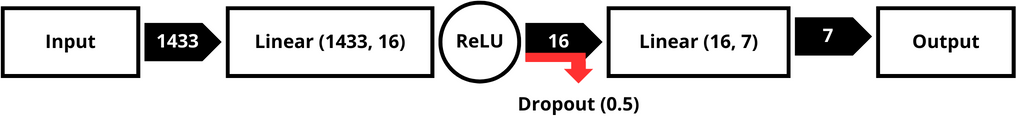

In [6]:
import torch
from torch.nn import Linear
import torch.nn.functional as F


class MLP(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(12345)
        self.lin1 = Linear(dataset.num_features, hidden_channels)
        self.lin2 = Linear(hidden_channels, dataset.num_classes)

    def forward(self, x):
        x = self.lin1(x)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin2(x)
        return x

model = MLP(hidden_channels=16)
print(model)

MLP(
  (lin1): Linear(in_features=1433, out_features=16, bias=True)
  (lin2): Linear(in_features=16, out_features=7, bias=True)
)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


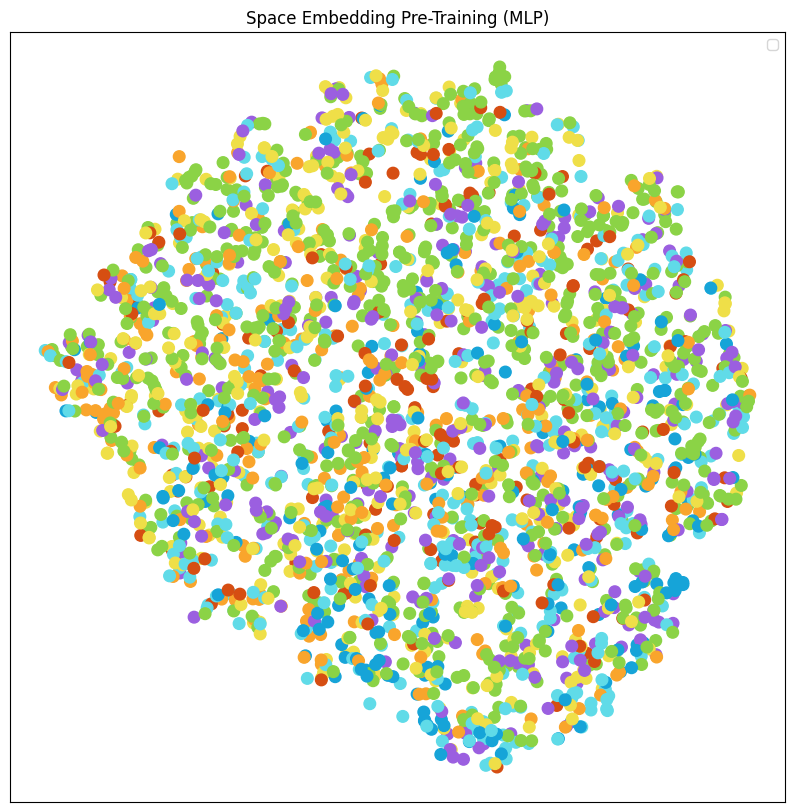

In [7]:
model = MLP(hidden_channels=16)
model.eval()
out_mlp = model(data.x)
visualize(out_mlp, color=data.y, title='Space Embedding Pre-Training (MLP)')

<IPython.core.display.Javascript object>

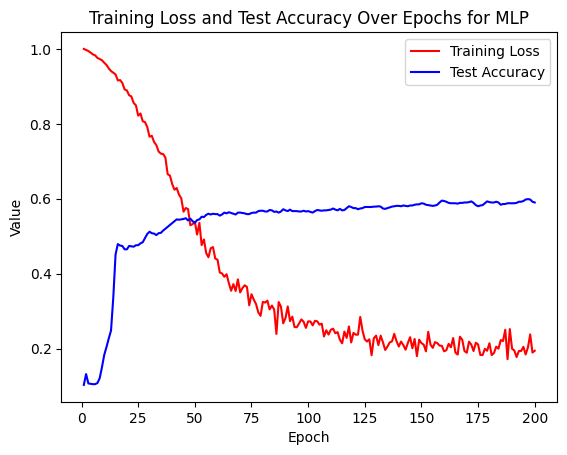

Test Accuracy: 0.5900


In [8]:
from IPython.display import Javascript  # Restrict height of output cell.
import matplotlib.pyplot as plt
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

model = MLP(hidden_channels=16)
criterion = torch.nn.CrossEntropyLoss()  # Define loss criterion.
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)  # Define optimizer.

def train():
      model.train()
      optimizer.zero_grad()  # Clear gradients.
      out = model(data.x)  # Perform a single forward pass.
      loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.
      return loss

def test():
      model.eval()
      out = model(data.x)
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
      test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
      return test_acc

loss = []
acc = []
for epoch in range(1, 201):
    loss.append(train().detach().numpy())
    acc.append(test())

plt.plot(range(1, 201), loss/max(loss), 'r', label='Training Loss')
plt.plot(range(1, 201), acc, 'b', label='Test Accuracy')
plt.title('Training Loss and Test Accuracy Over Epochs for MLP')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend()
plt.show()

# Model accuracy post-training
test_acc = test()
print(f'Test Accuracy: {test_acc:.4f}')

The **small amount of training nodes** leads to a heavy overfitting, and therefore generalizes poorly to unseen node representations.

It also fails to incorporate an important bias into the model: **Cited papers are very likely related to the category of a document**.
That is exactly where Graph Neural Networks come into play and can help to boost the performance of our model.


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


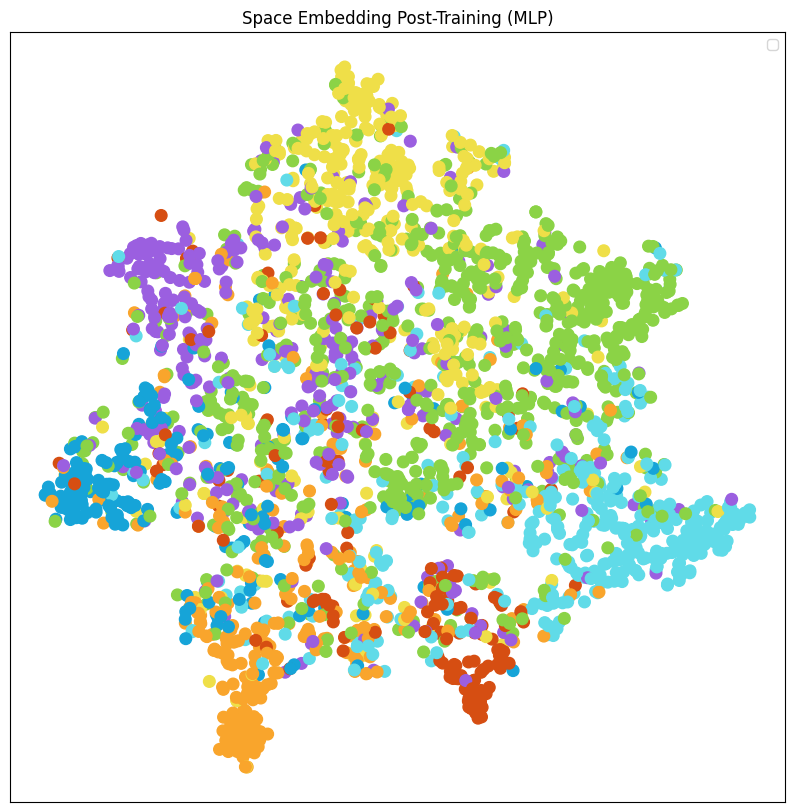

In [9]:
model.eval()
out_mlp = model(data.x)
visualize(out_mlp, color=data.y, title='Space Embedding Post-Training (MLP)')

# Training a Graph Neural Network (GNN)

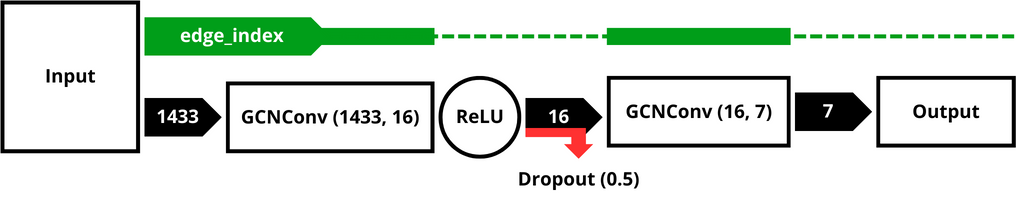

Let $( H^{(1)} )$ and $( H^{(2)} )$ be the hidden layer representations in a neural network with two layers. The activation functions are denoted by $( \sigma )$. The weight matrices are $( W^{(0)} )$ and $( W^{(1)} )$, and the input features are represented by $( H^{(0)} )$.

The propagation from the input layer $( H^{(0)} )$ to the first hidden layer $( H^{(1)} )$ is given by:

$$
H^{(1)} = \sigma(\tilde{D}^{-\frac{1}{2}} \tilde{A} \tilde{D}^{-\frac{1}{2}} H^{(0)}W^{(0)})
$$

Where:
- $( \tilde{D}^{-\frac{1}{2}} \tilde{A} \tilde{D}^{-\frac{1}{2}} )$ represents a matrix operation with dimensions $( (nume\_nodes, num\_nodes) )$.
- $( H^{(0)} )$ is the input matrix with dimensions $( (nume\_nodes, num\_features) )$.
- $( W^{(0)} )$ is the weight matrix connecting the input layer to the first hidden layer with dimensions $( (nume\_features, num\_hidden\_features) )$.

Similarly, the propagation from the first hidden layer $( H^{(1)} )$ to the second hidden layer $( H^{(2)} )$ is given by:

$$
H^{(2)} = \sigma(\tilde{D}^{-\frac{1}{2}} \tilde{A} \tilde{D}^{-\frac{1}{2}} H^{(1)}W^{(1)})
$$

Where:
- $( \tilde{D}^{-\frac{1}{2}} \tilde{A} \tilde{D}^{-\frac{1}{2}} )$ remains the same matrix operation with dimensions $( (nume\_nodes, num\_nodes) )$.
- $( H^{(1)} )$ is the hidden layer matrix with dimensions $( (nume\_nodes, num\_hidden\_features) )$.
- $( W^{(1)} )$ is the weight matrix connecting the first hidden layer to the second hidden layer with dimensions $( (num\_hidden\_features, num\_hidden\_features) )$.


In [10]:
from torch_geometric.nn import GCNConv


class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = GCNConv(dataset.num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x

model = GCN(hidden_channels=16)
print(model)

GCN(
  (conv1): GCNConv(1433, 16)
  (conv2): GCNConv(16, 7)
)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


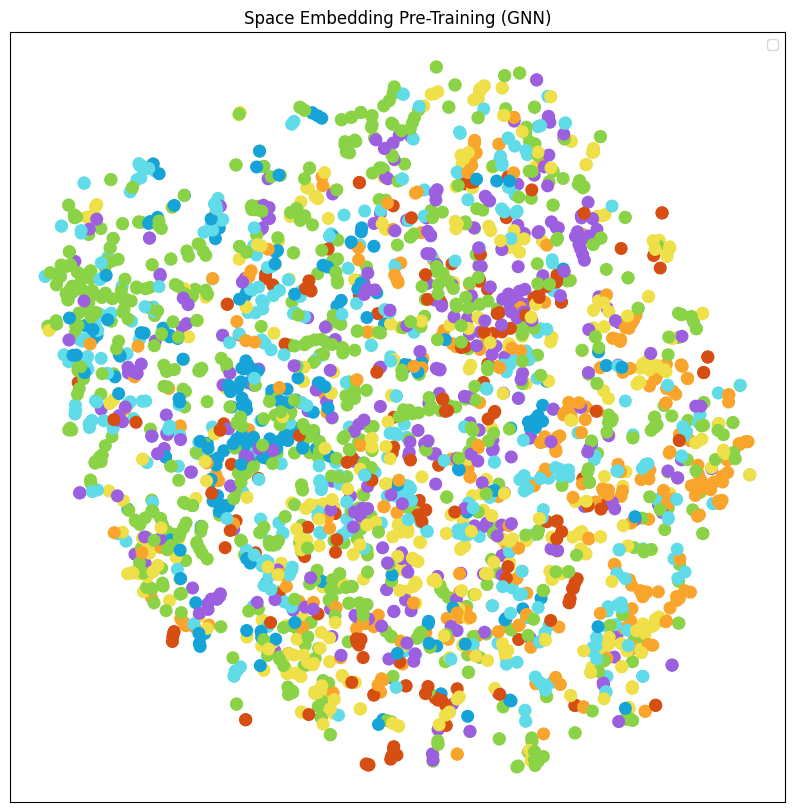

In [11]:
model = GCN(hidden_channels=16)
model.eval()
out_gnn = model(data.x, data.edge_index)
visualize(out_gnn, color=data.y, title='Space Embedding Pre-Training (GNN)')

<IPython.core.display.Javascript object>

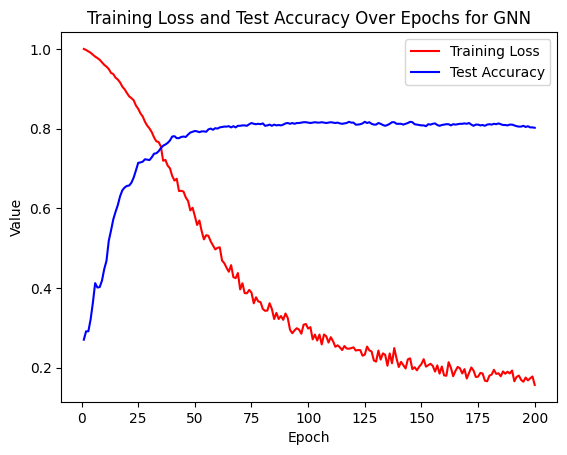

Test Accuracy: 0.8020


In [12]:
from IPython.display import Javascript  # Restrict height of output cell.
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

model = GCN(hidden_channels=16)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

def train():
      model.train()
      optimizer.zero_grad()  # Clear gradients.
      out = model(data.x, data.edge_index)  # Perform a single forward pass.
      loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.
      return loss

def test():
      model.eval()
      out = model(data.x, data.edge_index)
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
      test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
      return test_acc

loss = []
acc = []
for epoch in range(1, 201):
    loss.append(train().detach().numpy())
    acc.append(test())

plt.plot(range(1, 201), loss/max(loss), 'r', label='Training Loss')
plt.plot(range(1, 201), acc, 'b', label='Test Accuracy')
plt.title('Training Loss and Test Accuracy Over Epochs for GNN')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend()
plt.show()

# Model accuracy post-training
test_acc = test()
print(f'Test Accuracy: {test_acc:.4f}')

**Youpiii**, 
By simply swapping the linear layers with GNN layers, we can reach **81.5% of test accuracy**!

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


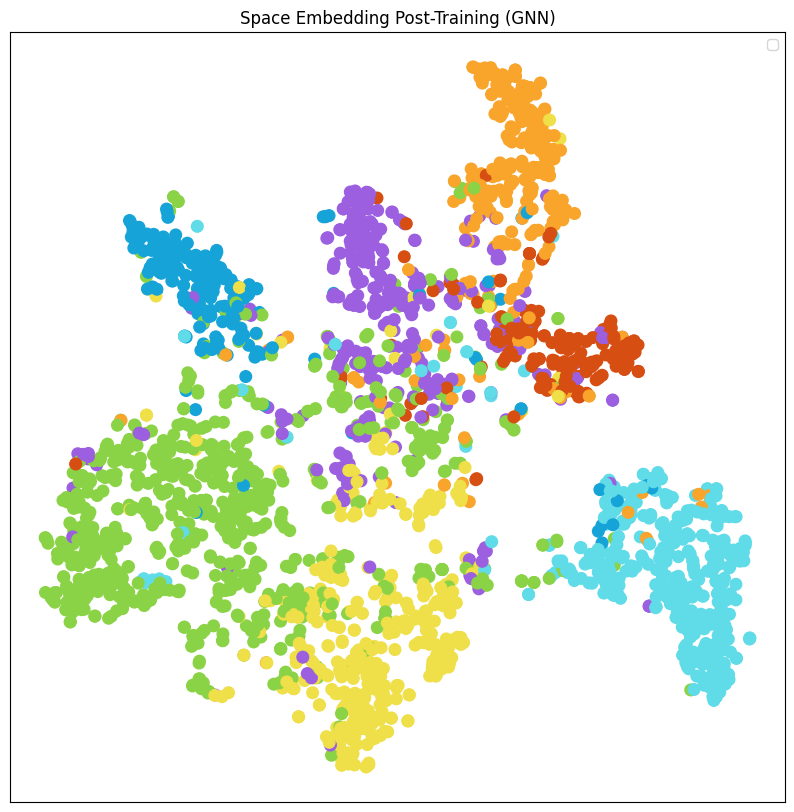

In [13]:
model.eval()
out_gnn = model(data.x, data.edge_index)
visualize(out_gnn, color=data.y, title='Space Embedding Post-Training (GNN)')